# 基于高斯玻色采样的聚类算法

聚类算法[1]是一种无监督学习算法，用于将数据集中的对象分组成为多个类别（或簇），使得同一类别内的对象彼此相似，而不同类别之间的对象则不相似。聚类算法的目标是发现数据中的内在结构，而无需预先标记数据。常见的经典聚类算法有K均值聚类(K_Means Clustering), 密度聚类(DBSCAN)， 谱聚类(Spectral Clustering)等方法。 

K均值聚类算法的核心是寻找聚类的中心， 首先随机选择K个中心点，然后计算每个数据点和中心点的距离，将其分类为最接近中心点$\mu_j$的组， 全部计算完成后将每个组的中心$\mu_j$重新计算，然后重复迭代这些步骤直到中心点不再更新就完成了聚类过程。密度聚类算法[2]能够识别出具有不同密度区域的数据点，并将它们分组为不同的簇。DBSCAN 的核心思想是根据数据点的密度来确定簇，而不是依赖于事先设定的簇的数量，DBSCAN使用的方法很简单，它任意选择一个没有类别的核心对象作为种子，然后找到所有这个核心对象能够密度可达的样本集合，即为一个聚类簇。接着继续选择另一个没有类别的核心对象去寻找密度可达的样本集合，这样就得到另一个聚类簇 （这样的得到都肯定是密度相连的），一直运行到所有核心对象都有类别为止。

与此同时高斯玻色采样也可以应用于聚类算法[3]， 根据前面的讨论可知高斯玻色采样用于图问题时， 图密度较大的子图对应的样本往往有较大概率被采到， 这些子图的节点对应的数据点就属于同一个聚类，因此通过这种方法就完成了一次聚类，然后将这个聚类对应的子图移除，继续高斯玻色采样过程，可以持续的找到多个不同的聚类。

# 算法说明

基于高斯玻色采样的算法如下
1. 通过分类数据集构造邻接矩阵A,
设置一个阈值距离$d_0$以及距离度量$D_{ij}=d(x_i,x_j)$, 邻接矩阵A的构造如下
$$A_{ij} = \begin{cases} 1 & D_{ij}\le d_0 \\
0 &  D_{ij}>d_0 \end{cases} $$

2. 将邻接矩阵A放入高斯玻色采样设备中进行N次采样。

3. 挑选出子图对应的采样结果，即只包含0，1的样本，计算每个子图密度，
设置一个阈值图密度$D_0$, 挑选出最大的子图，如果图密度大于$D_0$
则找到一个聚类，移除子图及其节点， 更新邻接矩阵A。 否则降低阈值图密度$D_0$，回到2

4. 当节点数剩余较少时停止迭代，完成聚类过程。

# 代码演示

这里采用西瓜数据集进行聚类， 每一个数据点包含密度和含糖率两个特征， 分别对应data_ws第一行和第二行。 

In [1]:
data_ws = np.array([[0.697,0.774,0.634,0.608,0.556,0.393,0.451,0.427,0.666,0.243,0.245,0.343,0.639,0.657,0.725,0.593, 0.6223, 0.75 ],
                [0.46,0.376,0.264,0.318,0.215,0.237,0.149,0.211,0.091,0.267,0.057,0.099,0.161,0.198,0.445,0.082, 0.062,0.405 ]])

<div style="margin-right: 15px; border-radius: 10px; background-color: rgb(255， 255， 255); text-align: center;">
    <img src="./fig/f1.png" width="60%"/>
    <p style="padding: 10px; font-size: small; text-align: center; line-height: 0%;">
        <b>
    </p>
</div>

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import deepquantum as dq
from deepquantum.photonic.app import gbs_clustering
from deepquantum.photonic.app.data import data
import matplotlib.pyplot as plt 
import networkx as nx
import torch 

选择合适的距离将数据点映射成对应图

In [4]:
#构造邻接矩阵
a = gbs_clustering.construct_adj_mat(data_ws, 0.2, gbs_clustering.distance)
g = nx.from_numpy_array(a)
# nx.draw(g,  pos=data_ws2.transpose(),with_labels=True)

<div style="margin-right: 15px; border-radius: 10px; background-color: rgb(255， 255， 255); text-align: center;">
    <img src="./fig/f2.png" width="50%"/>
    <p style="padding: 10px; font-size: small; text-align: center; line-height: 0%;">
        <b>
    </p>
</div>

开始第一轮寻找较大的稠密子图进行聚类

In [5]:
gbs = dq.photonic.ansatz.GBS_Graph(adj_mat=a, cutoff=2)
state = gbs()
sample_re = data.load_sample('clustering')

g_density = gbs.graph_density(g, sample_re)
D_0 = 0.8 #设置阈值图密度
max_node = 12 # 从较大的子图开始寻找
flag = False
while not flag:
    for i in sample_re:
        if sum(i.state)==max_node and g_density[i][1]>D_0:
            print(i)
            target = torch.nonzero(i.state).mT
            print(target)
            print(g_density[i])
            flag = True
    max_node = max_node - 2


|001110001000110110>
tensor([[ 2,  3,  4,  8, 12, 13, 15, 16]])
[tensor([2]), 0.8571428571428571]


这里成功的找到了第2，3，4，8，12，13，15，16个数据对应的稠密子图，也就是说这些数据应该被聚类在一起

2. 现在将第一轮找到的聚类节点移除，开始第二轮寻找较大的稠密子图进行聚类

<div style="margin-right: 15px; border-radius: 10px; background-color: rgb(255， 255， 255); text-align: center;">
    <img src="./fig/f3.png" width="60%"/>
    <p style="padding: 10px; font-size: small; text-align: center; line-height: 0%;">
        <b>
    </p>
</div>

In [7]:
data_ws2 = np.delete(data_ws, target,1)

3. 重复上面的高斯玻色采样过程,寻找最大的稠密子图

In [8]:
a_2 = gbs_clustering.construct_adj_mat(data_ws2, 0.2, gbs_clustering.distance)
g2 = nx.from_numpy_array(a_2)

<div style="margin-right: 15px; border-radius: 10px; background-color: rgb(255， 255， 255); text-align: center;">
    <img src="./fig/f5.png" width="50%"/>
    <p style="padding: 10px; font-size: small; text-align: center; line-height: 0%;">
        <b>
    </p>
</div>

In [20]:
gbs2 = dq.photonic.ansatz.GBS_Graph(adj_mat=a_2, cutoff=2)
state2 = gbs2()
sample_re2 = gbs2.sample(shots = 10000)

chain 5: 100%|███████████████████████████| 9999/9999 [00:00<00:00, 15948.60it/s]


In [22]:
g_density = gbs.graph_density(g2, sample_re2)
D_0 = 0.6 #设置阈值图密度, 需要不断调整
max_node = 10 # 从较大的子图开始寻找
flag = False
while not flag:
    for i in sample_re2:
        if sum(i.state)==max_node and g_density[i][1]>D_0:
            print(i)
            target = torch.nonzero(i.state).mT
            print(target)
            print(g_density[i])
            flag = True
    max_node = max_node - 2

|0011111100>
tensor([[2, 3, 4, 5, 6, 7]])
[tensor([39]), 0.6666666666666666]


这里成功的找到了处理后的第2，3，4，5，6，7个数据对应的稠密子图，也就是说这些数据应该被聚类在一起，同时剩下的四个点也应该被聚类在一起， 
因为他们对应的子图密度为1。经过上面的GBS算法我们可以看到原始数据就能够被分成3个聚类。最后的聚类结果如下。
<div style="margin-right: 15px; border-radius: 10px; background-color: rgb(255， 255， 255); text-align: center;">
    <img src="./fig/f4.png" width="60%"/>
    <p style="padding: 10px; font-size: small; text-align: center; line-height: 0%;">
        <b>
    </p>
</div>

<IPython.core.display.Javascript object>


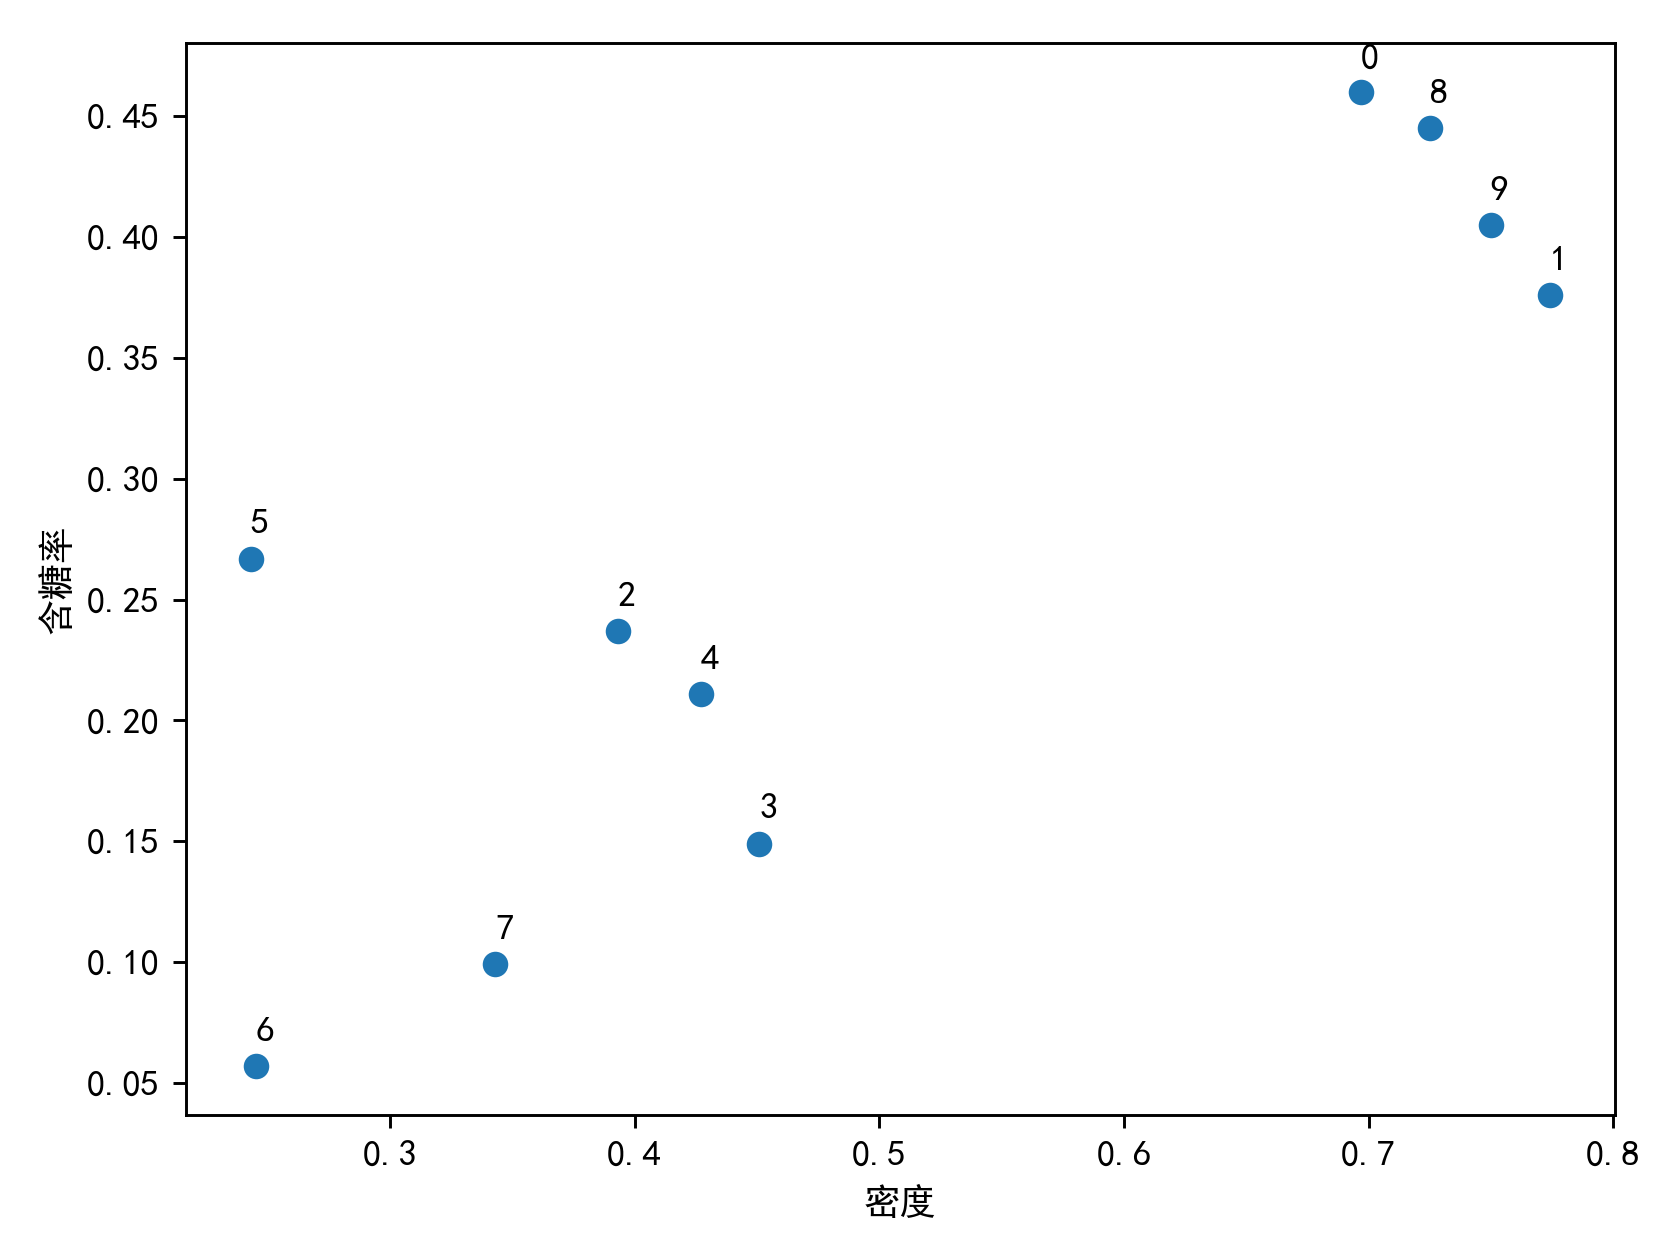

In [6]:
# %matplotlib notebook 
# plt.figure(dpi=150)
# plt.scatter(data_ws2[0], data_ws2[1])
# for i in range(10):
#     plt.text(data_ws2[:,i][0], data_ws2[:,i][1]+0.01, format(i) )
# plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.xlabel('密度')
# plt.ylabel('含糖率')
# plt.tight_layout()

# 附录

[1] S. J. Russell, P. Norvig, M.-W. Chang, J. Devlin, and
A. Dragan, Artificial Intelligence: A Modern Approach.
Hoboken: Pearson College Div, 4
th ed., Nov. 2020. 

[2]Schubert E, Sander J, Ester M, et al. DBSCAN revisited, revisited: why and how you should (still) use DBSCAN[J]. ACM Transactions on Database Systems (TODS), 2017, 42(3): 1-21.

[3]Bonaldi N, Rossi M, Mattioli D, et al. Boost clustering with Gaussian Boson Sampling: a full quantum approach[J]. arXiv preprint arXiv:2307.13348, 2023.
